In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = 10, 10

%matplotlib inline

In [2]:
enq_ga = pd.read_csv('../data/enq_data_ga.csv')
enq_dw = pd.read_csv('../data/enq_data_dw.csv')
booking = pd.read_csv('../data/booking_data_dw.csv')

In [3]:
enq_ga.head(3)
enq_ga_cols = ['Event label', 'Country', 'Date']
enq_ga.Date = pd.to_datetime(enq_ga.Date)

In [4]:
enq_dw.head(3)
enq_dw_cols = ['website_reference_number', 'created']
enq_dw.created = pd.to_datetime(enq_dw.created)

In [5]:
booking.head(3)
booking_cols = ['website_reference_number', 'booking_created_DT',
          'invoice_date', 'travel_date', 'ServiceGroupType', 'DESTINATION']
booking.booking_created_DT = pd.to_datetime(booking.booking_created_DT)

In [6]:
a = booking[booking.DESTINATION.isnull()].index.tolist()
a

[123, 462, 639, 1354, 1722, 2314, 2315, 2433]

In [7]:
booking.iloc[123, :]

fact_sales_id                                                 206620
BookingReference                                RA141050-1-1-1-1    
reference_number                                       RA-EN-1060864
website_reference_number                              RA-EN-20005891
BookingStatus               Confirmed                               
booking_created_DT                               2018-01-31 00:00:00
invoice_date                                              2018-01-31
ServiceGroupType                                       ACCOMMODATION
travel_date                                               2018-09-15
dim_enquiry_id                                                 63937
dim_serviceprovider_id                                          3894
Service_Provider_Name                            MalaMala Sable Camp
DESTINATION                                                      NaN
Exist in Enquiry Table                                           NaN
Exist in GA                       

In [8]:
enq_ga.loc[:, 'dummy'] = [1]*len(enq_ga)
enq_ga.set_index('Date', drop=False, inplace=True)

enq_dw.loc[:, 'dummy'] = [1]*len(enq_dw)
enq_dw.set_index('created', drop=False, inplace=True)

booking.loc[:, 'dummy'] = [1]*len(booking)
booking.set_index('booking_created_DT', drop=False, inplace=True)

In [9]:
dt = enq_ga[enq_ga_cols].merge(enq_dw[enq_dw_cols], how='inner', left_on='Event label',
            right_on='website_reference_number').merge(booking[booking_cols], how='inner',
                                                      left_on='Event label',
                                                      right_on='website_reference_number')

dt.drop('website_reference_number_y', axis=1, inplace=True)
dt.set_index('created', inplace=True, drop=False)
dt.index = pd.to_datetime(dt.index)

# cast dates
dt.created = pd.to_datetime(dt.created)
dt.booking_created_DT = pd.to_datetime(dt.booking_created_DT)
dt.invoice_date = pd.to_datetime(dt.invoice_date)
dt.travel_date = pd.to_datetime(dt.travel_date)

# remove NA Destinations
dt.dropna(axis=0, how='any', inplace=True)
dt.drop_duplicates(subset=['Event label', 'website_reference_number_x',
                          'created', 'DESTINATION'], inplace=True)
dt.head(6)

,Event label,Country,Date,website_reference_number_x,created,booking_created_DT,invoice_date,travel_date,ServiceGroupType,DESTINATION
created,,,,,,,,,,
2018-01-01 22:51:41,RA-EN-20006149,United States,2018-01-01,RA-EN-20006149,2018-01-01 22:51:41,2018-01-08,2018-01-29,2019-01-08,ACCOMMODATION,Greater Kruger Area
2018-01-01 22:51:41,RA-EN-20006149,United States,2018-01-01,RA-EN-20006149,2018-01-01 22:51:41,2018-01-08,2018-01-29,2019-01-08,ACCOMMODATION,Inhambane Province
2018-01-02 02:12:36,RA-EN-20006155,United States,2018-01-02,RA-EN-20006155,2018-01-02 02:12:36,2018-02-14,2018-02-19,2018-09-24,ACCOMMODATION,Chobe Region
2018-01-02 02:12:36,RA-EN-20006155,United States,2018-01-02,RA-EN-20006155,2018-01-02 02:12:36,2018-02-14,2018-02-19,2018-09-24,ACCOMMODATION,Victoria Falls Zimbabwe
2018-01-02 05:01:31,RA-EN-20006157,Malaysia,2018-01-02,RA-EN-20006157,2018-01-02 05:01:31,2018-06-21,2018-06-21,2019-08-13,ACCOMMODATION,Gauteng
2018-01-02 21:18:58,RA-EN-20006181,United States,2018-01-02,RA-EN-20006181,2018-01-02 21:18:58,2018-01-03,2018-01-10,2018-07-29,ACCOMMODATION,Madikwe Area


In [10]:
dt.shape

(2012, 10)

In [11]:
# countries = ['United States', 'United Kingdom', 'Australia','Canada']
# dt_countries = dt[dt.Country.isin(countries)]
dt_countries = dt.copy()
dt_countries.loc[:, 'dummy'] = [1]*len(dt_countries)
dt_countries.loc[:, 'day_part'] = [str(date)[:10] for date in dt_countries.index]

enq_to_book_days = ((dt.booking_created_DT - dt.created).dt.total_seconds()) / (60*60*24.0)
enq_to_book_days[enq_to_book_days < 0] = 0.0  # for days that come out negative

enq_to_travel_days = ((dt.travel_date - dt.created).dt.total_seconds()) / (60*60*24.0)
enq_to_travel_days[enq_to_travel_days < 0] = 0.0

dt_countries.loc[:, 'enq_to_book_days'] = enq_to_book_days
dt_countries.loc[:, 'enq_to_travel_days'] = enq_to_travel_days

dt_countries.loc[:, 'month'] = dt_countries.created.dt.month_name()

NameError: name 'countries' is not defined

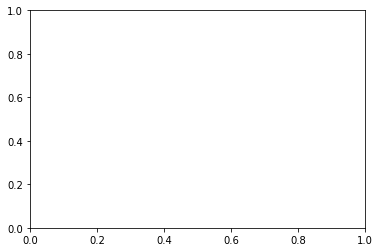

In [12]:
a = dt_countries.groupby(['Country', 'day_part'])['dummy'].count().unstack().fillna(value=0).stack()

a = a.reset_index()
a.index = pd.to_datetime(a.day_part)
a.Country = a.Country.astype('category')

fig, ax = plt.subplots()
for country in countries:
    data = a[a.Country == country]
    data.resample('w').sum().plot(ax=ax)

ax.set_ylabel('number of enquiries')
ax.set_xlabel('date')
    
plt.legend(countries)

### Distribution Julien suggest

#### Count of enquiries and the general distribution of e2b times

In [39]:
def plot_num_of_enq(destination, bound, data):
    data = data[data.DESTINATION == destination]
    
    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(14, 6)
    data['dummy'].resample('w').sum().plot(ax=ax[0])
    #data['enq_to_book_days'].resample('w').sum().plot(ax=ax[1])
    data['enq_to_book_days'][data.enq_to_book_days < 70].hist(bins=40, density=True, ax=ax[1])
    #data['enq_to_book_days'][data.enq_to_book_days < 50].plot.kde()
    
    ax0 = ax[0]; ax0.set(ylabel='Number of Enquiries')
    ax1 = ax[1]; ax1.set(xlabel='Number of Days to Booking', ylabel='% of bookings')
    
    q = data['enq_to_book_days'].quantile(q=bound)
    ax1.text(25, 0.12, str(bound*100)+'% of ' + str(destination)+ ' \nenquiries take less than\n '\
             +str(int(q)) + ' days to conver to booking.', fontsize=13)
    
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

interact(plot_num_of_enq, data=fixed(dt_countries),bound=widgets.FloatSlider(min=0,max=1,step=0.1,value=10),
         destination=dt_countries.DESTINATION.value_counts()[:7].index.tolist());

A Jupyter Widget

In [ ]:
widgets.FloatSlider()

In [15]:
def plot_num_of_enq(destination, data):
    data = data[data.DESTINATION == destination]
    
    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(16, 6)
    data['dummy'].resample('w').sum().plot(ax=ax[0])
    
    data.set_index('booking_created_DT', inplace=True)
    #data['enq_to_book_days'].resample('w').sum().plot(ax=ax[1])
    #data['enq_to_book_days'][data.enq_to_book_days < 70].hist(bins=40, ax=ax[1])
    #data['enq_to_book_days'][data.enq_to_book_days < 50].plot.kde()
    sns.boxplot(x='month', y='enq_to_book_days',  
                 data=dt_countries, ax=ax[1])
    
    ax0 = ax[0]; ax0.set(ylabel='Number of Enquiries')
    ax1 = ax[1]; ax1.set(xlabel='Number of Days to Booking', ylabel='Count')
    ax1.set_ylim(-1, 150)
    
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

interact(plot_num_of_enq, data=fixed(dt_countries), destination=dt_countries.DESTINATION.value_counts()[:7].index.tolist());

sns.boxplot(x='month', y='enq_to_book_days',  hue='Country', data=dt_countries, ax=ax)

A Jupyter Widget

In [183]:
dt_countries['enq_to_book_days'].median()

6.351296296296296

#### Count of Enquiries over enquiry time and Count of bookings over booking times

In [125]:
def plot_num_of_enq(destination, data):
    data = data[data.DESTINATION == destination]
    
    fig, ax = plt.subplots()
    fig.set_size_inches(14, 7)
    data['dummy'].resample('w').sum().plot(ax=ax)
    ax.set_ylabel('number of enquiries', color='b')
    ax.tick_params('y', colors='b')
    
    ax2 = ax.twinx()
    data.set_index('booking_created_DT', inplace=True)
    data['dummy'].resample('w').sum().plot(ax=ax2, color='r')
    #ax2.set(xlabel='Date', ylabel='number of bookings')
    ax2.set_ylabel('number of bookings', color='r')
    ax2.tick_params('y', colors='r')
    ax2.tick_params('y', colors='r')
    
    ax.grid(True)
    
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

interact(plot_num_of_enq, data=fixed(dt_countries), destination=dt_countries.DESTINATION.value_counts()[:7].index.tolist())

A Jupyter Widget

<function __main__.plot_num_of_enq>

### Time to book

In [80]:
enq_to_book_days = ((dt.booking_created_DT - dt.created).dt.total_seconds()) / (60*60*24.0)
enq_to_book_days[enq_to_book_days < 0] = 0.0  # for days that come out negative

enq_to_travel_days = ((dt.travel_date - dt.created).dt.total_seconds()) / (60*60*24.0)
enq_to_travel_days[enq_to_travel_days < 0] = 0.0

dt_countries.loc[:, 'enq_to_book_days'] = enq_to_book_days
dt_countries.loc[:, 'enq_to_travel_days'] = enq_to_travel_days

dt_countries.loc[:, 'month'] = dt_countries.created.dt.month_name()

C:\Users\Fabusuyi\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Fabusuyi\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


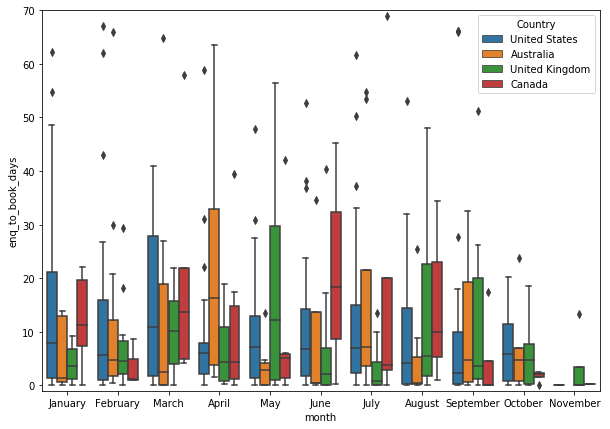

In [18]:
fig, ax = plt.subplots()
fig.set_size_inches(10,7)
ax.set_ylim(-1, 70)
sns.boxplot(x='month', y='enq_to_book_days',  hue='Country', data=dt_countries, ax=ax)

### TIme to travel

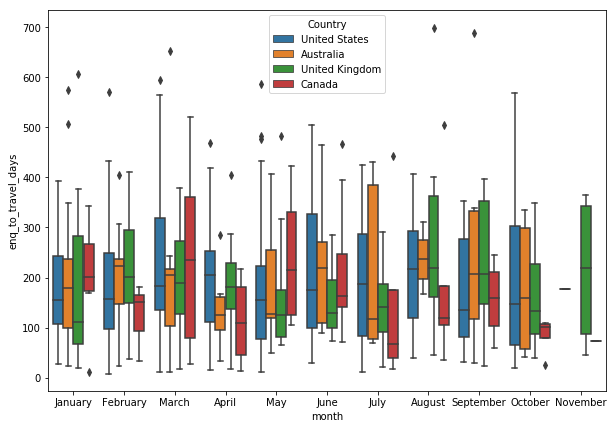

In [19]:
fig, ax = plt.subplots()
fig.set_size_inches(10,7)
#ax.set_ylim(-1, 70)
sns.boxplot(x='month', y='enq_to_travel_days',  hue='Country', data=dt_countries, ax=ax)

In [ ]:
# slider = widgets.IntSlider(min=1, max=12, value=4, description='Hours')
# interact(plot_time_dist, df=fixed(enq), freq=slider, x=fixed('hr'), 
#          factor=fixed('weekend?'), thresh=fixed(20000), ax=fixed(None), order=fixed(None));

In [176]:
def plot_dist(destination, data=dt_countries):
    dt = dt_countries[dt_countries.DESTINATION == destination]
    
    fig, ax = plt.subplots()
    fig.set_size_inches(10,7)
    
    sns.boxplot(x='month', y='enq_to_book_days',  
                data=dt, ax=ax)

    

from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

interact(plot_dist, data=fixed(dt_countries), destination=dt_countries.DESTINATION.value_counts()[:7].index.tolist())
    


A Jupyter Widget

<function __main__.plot_dist>

In [27]:
dt_countries.DESTINATION.value_counts()[:7].index.tolist()

['Greater Kruger Area',
 'Cape Town',
 'Gauteng',
 'Victoria Falls Zimbabwe',
 'Chobe Region',
 'Garden Route',
 'Moremi and Okavango Region']

In [154]:
def plot_enq_book(destination, enq_ga=enq_ga, enq_dw=enq_dw, booking=booking):
    booking = booking[booking.DESTINATION == destination]
    
    
    fig, ax = plt.subplots()
    fig.set_size_inches(14, 7)
    enq_ga['dummy'].resample('w').sum().plot(ax=ax)
    ax.set_ylabel('number of enquiries', color='b')
    ax.tick_params('y', colors='b')
    
    ax2 = ax.twinx()
    #data.set_index('booking_created_DT', inplace=True)
    booking['dummy'].resample('w').sum().plot(ax=ax2, color='r')
    #ax2.set(xlabel='Date', ylabel='number of bookings')
    ax2.set_ylabel('number of bookings', color='r')
    ax2.tick_params('y', colors='r')
    ax2.tick_params('y', colors='r')
    
    ax.grid(True); ax.set_title('Enquiries and Bookings (red)', fontsize=17)
    ax.set
    
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

interact(plot_enq_book, enq_ga=fixed(enq_ga), enq_dw=fixed(enq_dw), booking=fixed(booking),
         destination=booking.DESTINATION.value_counts()[:7].index.tolist())

A Jupyter Widget

<function __main__.plot_enq_book>